In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, read_csv, concat
from arviz import hdi
sns.set_theme(style='ticks', context='notebook', font_scale=1.2)

## Section 1: Model Diagnostics

In [2]:
## Define parameters.
models = ['pgng_m1', 'pgng_m2', 'pgng_m3', 'pgng_m4', 'pgng_m5', 'pgng_m6', 'pgng_m7']
sessions = ['s1', 's2', 's3', 's4']

### 1.1 Stan diagnostics


In [4]:
## Main loop.
diagnostics = []
for m in models:
    
    for s in sessions:
        
        ## Load Stan summary.
        samples = read_csv(os.path.join('stan_results', s, f'{m}.tsv.gz'), sep='\t', compression='gzip')
        summary = read_csv(os.path.join('stan_results', s, f'{m}_summary.tsv'), sep='\t', index_col=0)
        ppc = read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))

        ## Apply restrictions.
        ppc = ppc[~np.isinf(ppc.k_u)]

        ## Identify number of divergences.
        divergence = samples.divergent__.sum()

        ## Identify parameters failing to reach convergence.
        rhat = len(summary.query('R_hat >= 1.02'))
        
        ## Identify parameters with low effective sample size.
        n_eff = len(summary.query('N_Eff < 400'))

        ## Identify number of effective parameters.
        p_loo = ppc.pwaic.sum()

        ## Identify number of poorly predicted observations.
        pk = np.sum(ppc.k_u > 0.7)

        ## Convert to dictionary. Append.
        diagnostics.append(dict(
            model = m,
            session = s,
            divergence = divergence,
            rhat = rhat,
            n_eff = n_eff,
            p_loo = np.round(p_loo, 1),
            pk = np.round(pk, 3)
        ))

## Convert to DataFrame.
diagnostics = DataFrame(diagnostics).sort_values(['session','model']).set_index(['session','model'])
diagnostics

divergence  rhat  n_eff  p_loo  pk
session model                                      
s1      pgng_m1         0.0     0      0   21.1   7
        pgng_m2         0.0     0      1   35.6   2
        pgng_m3         0.0     0      0   48.2   0
        pgng_m4         0.0     0      3   54.6   0
        pgng_m5         0.0     0      0   54.4   0
        pgng_m6         0.0     0      0   62.5   0
        pgng_m7         0.0     0      1   68.5   0
s2      pgng_m1         0.0     0      0   12.1   4
        pgng_m2         0.0     0      0   25.9   0
        pgng_m3         0.0     0      0   35.9   0
        pgng_m4         0.0     3      4   41.1   4
        pgng_m5         0.0     0      0   40.5   0
        pgng_m6         0.0     0      0   44.2   3
        pgng_m7         0.0     0      0   47.0  12
s3      pgng_m1         0.0     0      0    9.8   0
        pgng_m2         0.0     0      0   21.0   2
        pgng_m3         0.0     0      0   29.4   2
        pgng_m4         0.0     0      0   36.0   1
        pgng_m5         0.0     0      0   34.7  16
        pgng_m6         0.0     0      0   37.0   8
        pgng_m7         0.0     0      0   40.6   6
s4      pgng_m1         0.0     0      0    9.5  16
        pgng_m2         0.0     0      0   21.2   7
        pgng_m3         0.0     0      0   30.8   2
        pgng_m4         0.0     0      0   35.3  58
        pgng_m5         0.0     0      0   35.2  64
        pgng_m6         0.0     0      0   36.8  77
        pgng_m7         0.0     0      0   41.0   6

## Section 2: Model Comparison

In [5]:
## Define parameters.
models = ['pgng_m1', 'pgng_m2', 'pgng_m3', 'pgng_m4', 'pgng_m5', 'pgng_m6', 'pgng_m7']
sessions = ['s1', 's2', 's3', 's4']

### 2.1 LOO-CV indices

In [6]:
## Main loop.
loocv = []
for m in models:

    for s in sessions:
    
        ## Load posterior predictive check.
        ppc = read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))

        ## Compute LOO-CV.
        loo = -2 * ppc.loo.sum()

        ## Convert to dictionary. Append.
        loocv.append(dict(model=m, session=s, loocv=loo))
        
## Convert to DataFrame.
loocv = DataFrame(loocv).pivot_table('loocv', 'session', 'model')
loocv.round(1)

model,pgng_m1,pgng_m2,pgng_m3,pgng_m4,pgng_m5,pgng_m6,pgng_m7
session,,,,,,,
s1,-37241.1,-38327.4,-38992.9,-39145.6,-39129.9,-39190.3,-39291.4
s2,-38446.8,-38979.3,-39492.8,-39644.9,-39629.8,-39666.1,-39914.8
s3,-38350.9,-38777.0,-38971.4,-39066.7,-39072.2,-39093.8,-39279.5
s4,-37419.1,-37928.1,-38360.7,-38404.5,-38434.0,-38451.6,-38574.7


### 2.2 Model comparisons

In [7]:
from itertools import combinations

loocv = []
for s in sessions:

    for a, b in list(combinations(models, 2)):

        ## Load data.
        ppc1 = read_csv(os.path.join('stan_results', s, f'{a}_ppc.csv'))
        ppc2 = read_csv(os.path.join('stan_results', s, f'{b}_ppc.csv'))
            
        arr = -2 * (ppc2.loo - ppc1.loo)

        ## Compute stats.
        N = len(ppc1)
        mu = np.sum(arr)
        se = np.std(arr) * np.sqrt(N)

        ## Convert to dictionary. Append.
        loocv.append(dict(model=m, session=s, a=a, b=b, loocv='%0.1f (%0.1f)' %(mu, se)))
        
## Convert to DataFrame.
loocv = DataFrame(loocv).pivot_table('loocv', 'a', ['session','b'], aggfunc=lambda x: x).fillna('-')
loocv

session              s1                                                  \
b               pgng_m2         pgng_m3         pgng_m4         pgng_m5   
a                                                                         
pgng_m1  -1086.3 (31.0)  -1751.8 (39.2)  -1904.5 (41.3)  -1888.8 (42.0)   
pgng_m2               -   -665.5 (25.5)   -818.1 (28.4)   -802.5 (29.3)   
pgng_m3               -               -   -152.7 (13.4)   -137.0 (15.6)   
pgng_m4               -               -               -      15.7 (9.4)   
pgng_m5               -               -               -               -   
pgng_m6               -               -               -               -   

session                                             s2                  \
b               pgng_m6         pgng_m7        pgng_m2         pgng_m3   
a                                                                        
pgng_m1  -1949.2 (42.3)  -2050.3 (42.9)  -532.5 (21.2)  -1046.0 (29.9)   
pgng_m2   -862.9 (29.9)   -964.0 (30.7)              -   -513.5 (21.2)   
pgng_m3   -197.4 (16.4)   -298.5 (17.7)              -               -   
pgng_m4     -44.7 (8.7)   -145.8 (11.1)              -               -   
pgng_m5     -60.4 (6.7)    -161.5 (8.9)              -               -   
pgng_m6               -    -101.1 (6.7)              -               -   

session                                  ...             s3                 \
b               pgng_m4         pgng_m5  ...        pgng_m4        pgng_m5   
a                                        ...                                 
pgng_m1  -1198.1 (32.1)  -1182.9 (32.1)  ...  -715.8 (24.7)  -721.3 (24.5)   
pgng_m2   -665.6 (24.5)   -650.5 (24.6)  ...  -289.6 (16.7)  -295.1 (16.4)   
pgng_m3   -152.2 (12.6)   -137.0 (12.7)  ...   -95.2 (10.1)   -100.7 (9.3)   
pgng_m4               -      15.2 (6.1)  ...              -     -5.5 (5.7)   
pgng_m5               -               -  ...              -              -   
pgng_m6               -               -  ...              -              -   

session                                           s4                 \
b              pgng_m6        pgng_m7        pgng_m2        pgng_m3   
a                                                                     
pgng_m1  -742.9 (25.2)  -928.6 (26.5)  -509.0 (20.9)  -941.6 (28.4)   
pgng_m2  -316.7 (17.4)  -502.5 (19.1)              -  -432.6 (19.9)   
pgng_m3  -122.3 (11.1)  -308.1 (14.7)              -              -   
pgng_m4    -27.1 (4.3)  -212.8 (11.6)              -              -   
pgng_m5    -21.6 (4.2)  -207.3 (11.3)              -              -   
pgng_m6              -  -185.7 (10.8)              -              -   

session                                                                 
b              pgng_m4         pgng_m5         pgng_m6         pgng_m7  
a                                                                       
pgng_m1  -985.4 (29.5)  -1014.9 (29.3)  -1032.5 (29.9)  -1155.6 (30.7)  
pgng_m2  -476.3 (21.8)   -505.9 (21.3)   -523.5 (22.2)   -646.6 (23.5)  
pgng_m3    -43.8 (8.7)     -73.3 (7.2)     -90.9 (9.4)   -214.1 (11.8)  
pgng_m4              -     -29.6 (5.6)     -47.2 (5.1)    -170.3 (9.3)  
pgng_m5              -               -     -17.6 (4.1)    -140.7 (8.5)  
pgng_m6              -               -               -    -123.1 (7.6)  

[6 rows x 24 columns]

## Section 3: Posterior Predictive Checks

In [12]:
## Define parameters.
models = ['pgng_m1', 'pgng_m2', 'pgng_m3', 'pgng_m4', 'pgng_m5', 'pgng_m6', 'pgng_m7']
sessions = ['s1', 's2', 's3', 's4']

### 3.1 Group-level

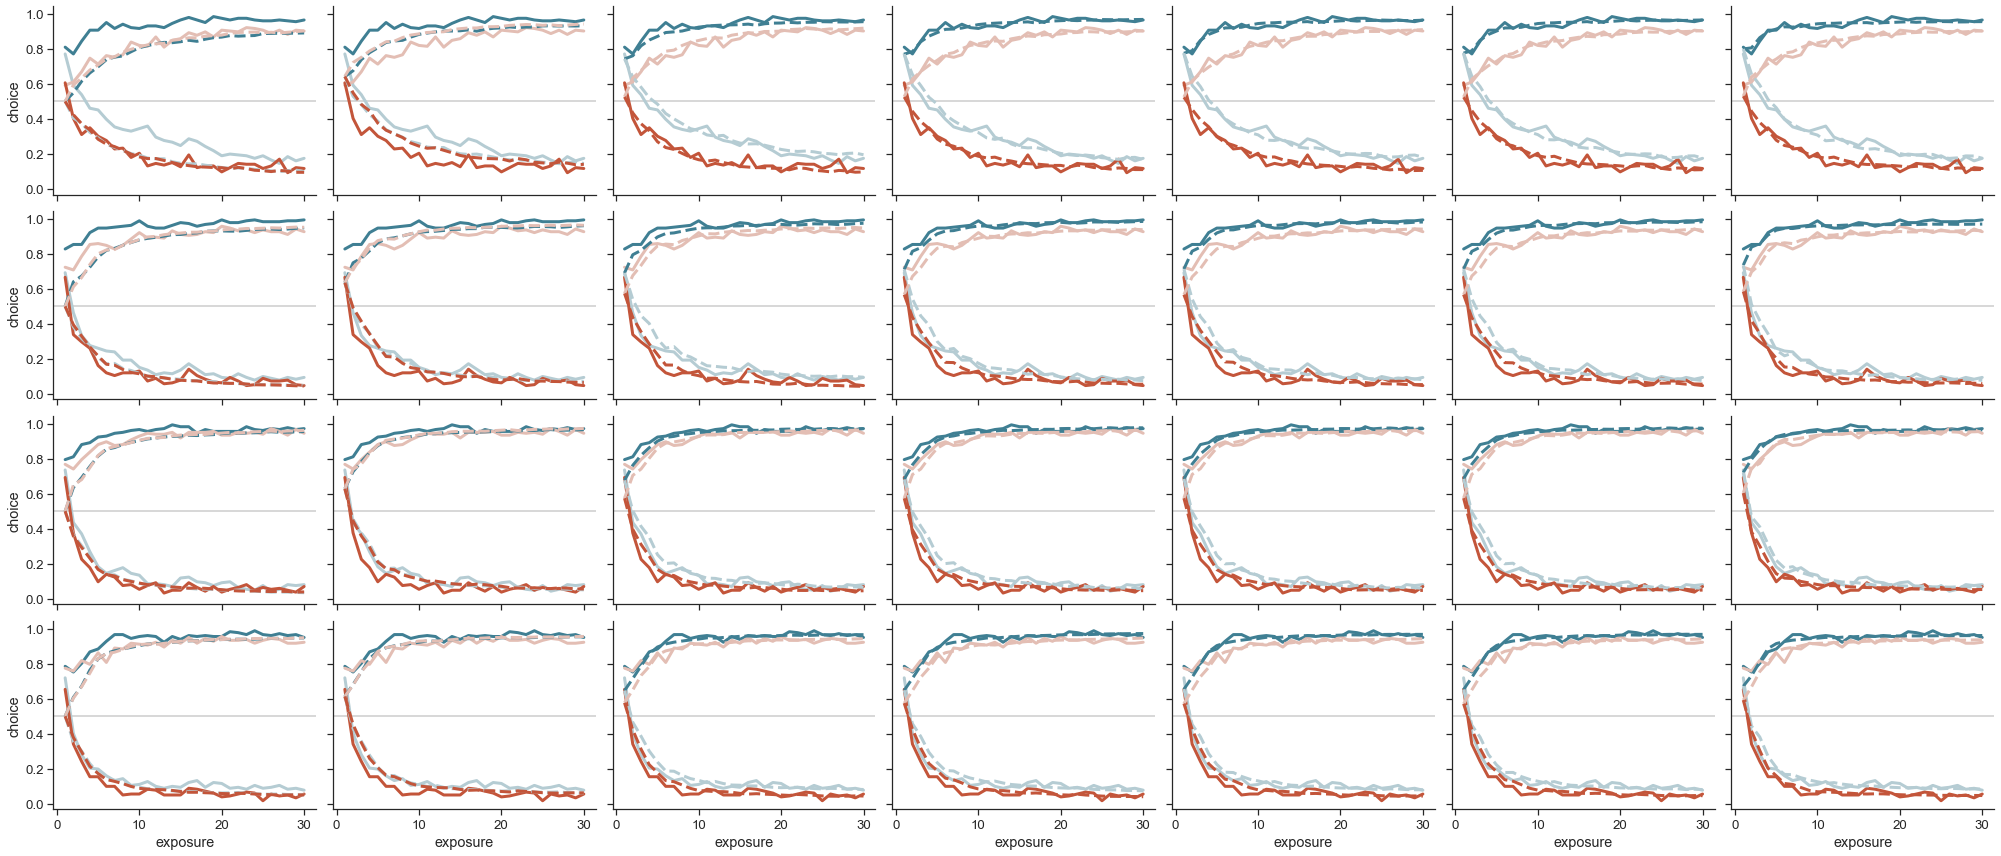

In [13]:
## Initialize canvas.
fig, axes = plt.subplots(len(sessions), len(models), figsize=(len(models)*4, len(sessions)*3),
                         sharex=True, sharey=True)

## Define aesthetics.
order = ['gw', 'ngw', 'gal', 'ngal']
palette = sns.diverging_palette(220, 20, n=4)

for i, s in enumerate(sessions):
    
    for j, m in enumerate(models):
        
        ## Load posterior predictive check.
        ppc = read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))

        ## Plot learning curves.
        sns.lineplot(x='exposure', y='choice', hue='robot', data=ppc, hue_order=order,
                      palette=palette, lw=3, ci=None, ax=axes[i,j])
        sns.lineplot(x='exposure', y='Y_hat', hue='robot', data=ppc, hue_order=order, 
                      palette=palette, lw=3, ci=None, linestyle='--', ax=axes[i,j])

        ## Add trend line.
        axes[i,j].axhline(0.5, color='0.5', alpha=0.4, zorder=-10)
        
        ## Adjust legend.
        axes[i,j].legend_.set_visible(False)
        
sns.despine()
plt.tight_layout()

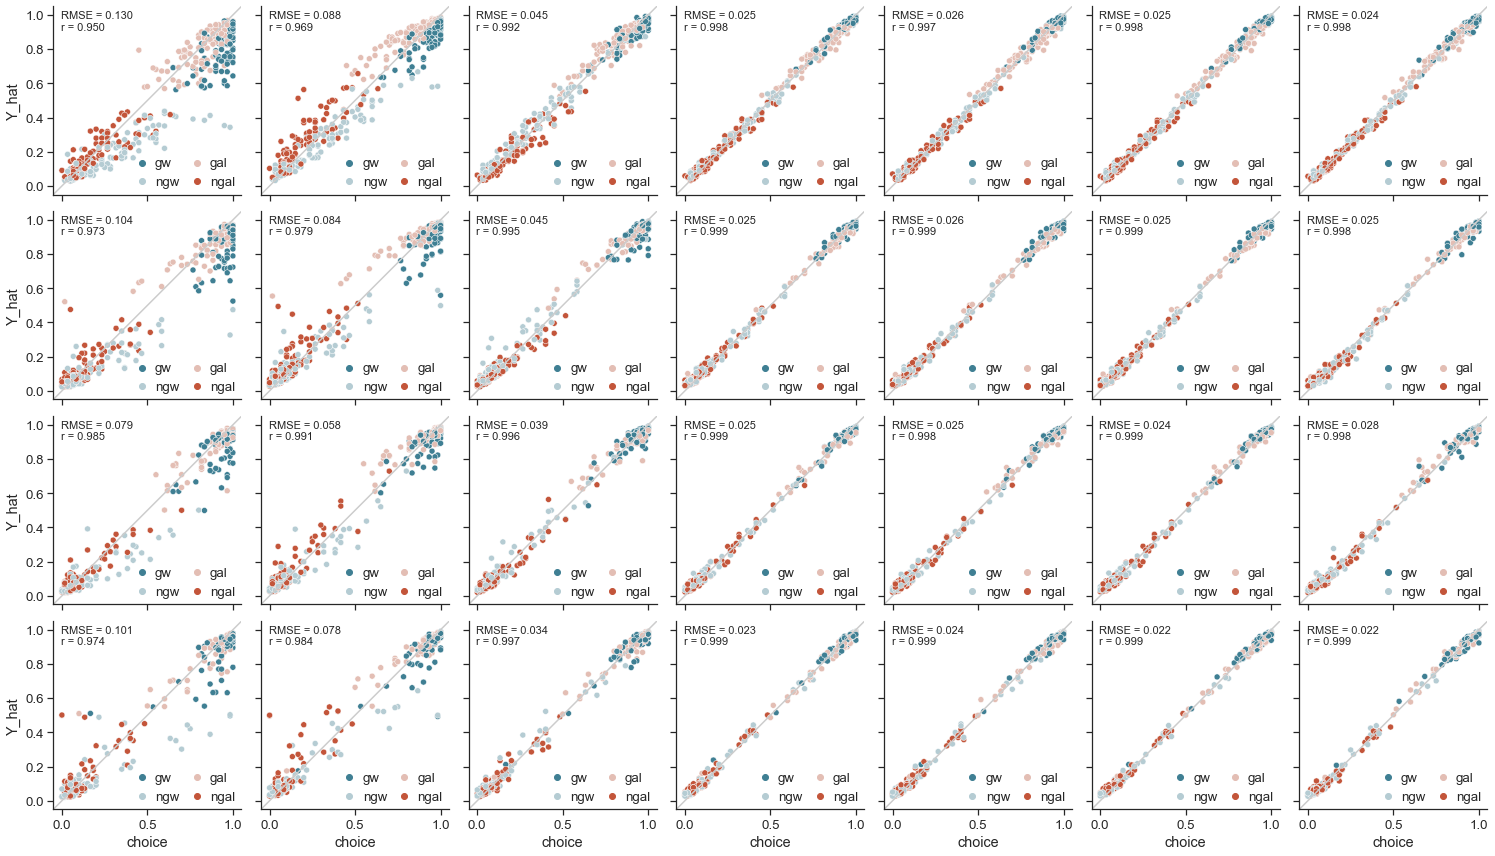

In [14]:
## Initialize canvas.
fig, axes = plt.subplots(len(sessions), len(models), figsize=(len(models)*3, len(sessions)*3),
                         sharex=True, sharey=True)

## Define aesthetics.
order = ['gw', 'ngw', 'gal', 'ngal']
palette = sns.diverging_palette(220, 20, n=4)

## Define convenience functions.
RMSE = lambda x: np.sqrt(np.mean(np.square(x)))

for i, s in enumerate(sessions):
    
    for j, m in enumerate(models):
        
        ## Load posterior predictive check.
        ppc = read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))

        ## Compute accuracy by participant / condition.
        gb = ppc.groupby(['subject','robot']).agg({'choice':'mean', 'Y_hat':'mean'}).reset_index()
        
        ## Compute fit statistics.
        rmse = RMSE(gb.choice - gb.Y_hat)
        corr = gb[['choice','Y_hat']].corr().values[0,1]
        
        ## Plot learning curves.
        sns.scatterplot(x='choice', y='Y_hat', hue='robot', data=gb, hue_order=order, 
                        palette=palette, ax=axes[i,j])
        axes[i,j].plot([-1,2], [-1,2], color='0.8')
        
        ## Adjust x-axis.
        axes[i,j].set(xlim=(-0.05,1.05))
        
        ## Adjust y-axis
        axes[i,j].set(ylim=(-0.05,1.05))
        
        ## Adjust legend.
        axes[i,j].legend(loc=4, frameon=False, ncol=2, borderpad=0, handletextpad=0, columnspacing=0.3)
        
        ## Add annotation.
        annot = 'RMSE = %0.3f\nr = %0.3f' %(rmse, corr)
        axes[i,j].annotate(annot, (0,0), (0.04, 0.98), 'axes fraction', ha='left', va='top', fontsize=11)
        
sns.despine()
plt.tight_layout()

## Section 4: Group-level parameters

In [39]:
## Define parameters.
model = 'pgng_m7'
sessions = ['s1', 's2', 's3', 's4']
cols = ['Session','Mean','StdDev','2.5%','50%','97.5%']

## Iteratively load Stan summaries.
summary = concat([
    read_csv(os.path.join('stan_results', s, f'{model}_summary.tsv'), sep='\t', index_col=0).assign(Session=s)
    for s in sessions
])

## Restrict to group-level parameters.
summary = summary.T.filter(regex='_mu').T[cols].reset_index().set_index(['index','Session']).sort_index()

### 4.1 Inverse temperatures

In [43]:
summary.loc[['b1_mu','b2_mu']]

Mean StdDev    2.5%     50%   97.5%
index Session                                       
b1_mu s1        12.07   0.97   10.16   12.04   13.94
      s2        32.63   4.01   25.31    32.4   40.69
      s3       33.296  3.932  25.949  33.035  41.412
      s4        32.03   4.14   24.54   31.69   40.73
b2_mu s1         13.6   1.77   10.57    13.4   17.44
      s2        30.23   3.95   23.19   29.89   38.19
      s3       31.262  3.994  23.941  30.975  39.447
      s4        29.46   3.82   22.61   29.12   37.43

### 4.2 Go biases

In [44]:
summary.loc[['b3_mu','b4_mu']]

Mean StdDev   2.5%    50%  97.5%
index Session                                   
b3_mu s1        1.84   0.14   1.56   1.84   2.13
      s2        1.36   0.15   1.05   1.35   1.65
      s3        1.17  0.124  0.923  1.168  1.413
      s4        0.95   0.15   0.65   0.94   1.23
b4_mu s1        0.14   0.06   0.02   0.14   0.25
      s2         0.4   0.11   0.18    0.4   0.62
      s3       0.502  0.107  0.292  0.501  0.705
      s4        0.44   0.13   0.18   0.44    0.7

### 4.3 Learning rates

In [45]:
summary.loc[['a1_mu','a2_mu']]

Mean StdDev   2.5%    50%  97.5%
index Session                                   
a1_mu s1        0.19   0.02   0.15   0.19   0.23
      s2        0.11   0.01   0.08   0.11   0.14
      s3       0.109  0.014  0.082  0.108  0.136
      s4        0.11   0.01   0.08   0.11   0.14
a2_mu s1        0.11   0.03   0.06   0.11   0.17
      s2        0.09   0.02   0.06   0.09   0.12
      s3       0.107  0.016  0.075  0.106  0.136
      s4         0.1   0.01   0.07    0.1   0.12

### 4.4 Lapse rates

In [46]:
summary.loc[['c1_mu']]

Mean StdDev   2.5%    50%  97.5%
index Session                                   
c1_mu s1        0.01    0.0    0.0   0.01   0.02
      s2        0.01    0.0   0.01   0.01   0.02
      s3       0.008  0.004  0.002  0.007  0.015
      s4        0.01    0.0    0.0   0.01   0.01

## Section 5: Parameter stability

## Section 6: Reliability

In [34]:
## Define paramaters.
model = 'pgng_m7'

## Load summary.
reliability = read_csv(os.path.join('stan_results', f'{model}_reliability.csv'))

### 6.1 Split-half reliability

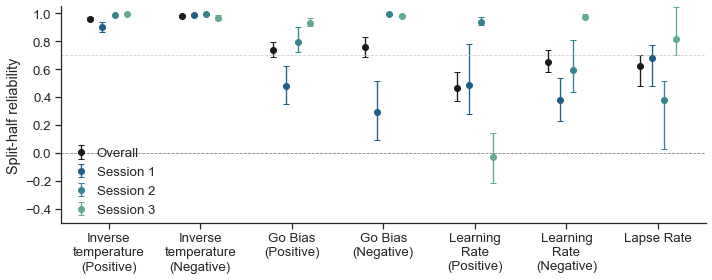

In [35]:
## Initialize canvas.
fig, ax = plt.subplots(1, 1, figsize=(10,4))
palette = np.append('k', sns.color_palette('crest_r', n_colors=3).as_hex())
labels = ['Overall','Session 1','Session 2', 'Session 3']
offsets = np.linspace(-0.2,0.2,4)

for i, (offset, color, label) in enumerate(zip(offsets, palette, labels)):

    ## Define points.
    y = reliability.query(f'Type == "sh" and Group == {i}').Mean
    x = np.arange(len(y)) + offset
    yerr = np.array([
        reliability.query(f'Type == "sh" and Group == {i}')['97.5%'] - y,
        y - reliability.query(f'Type == "sh" and Group == {i}')['2.5%']
    ])
    
    ## Plot.
    ax.errorbar(x, y, fmt='o', yerr=yerr, color=color, label=label, capsize=3, elinewidth=1.33)
    
## Add detail.
ax.axhline(0.7, color='0.8', lw=0.8, linestyle='--')
ax.axhline(0.0, color='0.5', lw=0.8, linestyle='--')
ax.legend(loc=3, frameon=False, borderpad=0, handletextpad=0.2)
ax.set(xticks=np.arange(7), ylim=(-0.5,1.05), ylabel='Split-half reliability')
ax.set_xticklabels(['Inverse\ntemperature\n(Positive)','Inverse\ntemperature\n(Negative)',
                    'Go Bias\n(Positive)','Go Bias\n(Negative)','Learning\nRate\n(Positive)',
                    'Learning\nRate\n(Negative)','Lapse Rate'])

sns.despine()
plt.tight_layout()

### 6.2 Test-retest reliability

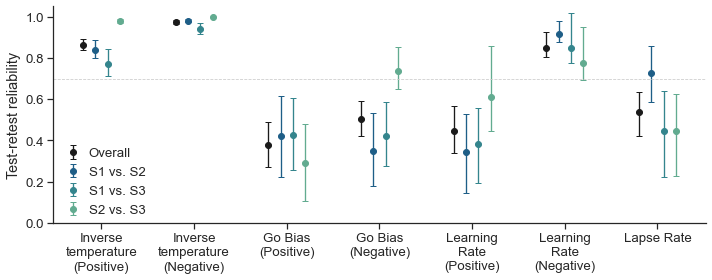

In [36]:
## Initialize canvas.
fig, ax = plt.subplots(1, 1, figsize=(10,4))
palette = np.append('k', sns.color_palette('crest_r', n_colors=3).as_hex())
labels = ['Overall','S1 vs. S2','S1 vs. S3', 'S2 vs. S3']
offsets = np.linspace(-0.2,0.2,len(labels))

for i, (offset, color, label) in enumerate(zip(offsets, palette, labels)):

    ## Define query.
    query = f'Type == "trt" and Group == {i}'
    
    ## Define points.
    y = reliability.query(query).Mean
    x = np.arange(len(y)) + offset
    yerr = np.array([
        reliability.query(query)['97.5%'] - y,
        y - reliability.query(query)['2.5%']
    ])
    
    ## Plot.
    ax.errorbar(x, y, fmt='o', yerr=yerr, color=color, label=label, capsize=3, elinewidth=1.33)
    
## Add detail.
ax.axhline(0.7, color='0.8', lw=0.8, linestyle='--')
ax.legend(loc=3, frameon=False, borderpad=0, handletextpad=0.2)
ax.set(xticks=np.arange(7), ylim=(0,1.05), ylabel='Test-retest reliability')
ax.set_xticklabels(['Inverse\ntemperature\n(Positive)','Inverse\ntemperature\n(Negative)',
                    'Go Bias\n(Positive)','Go Bias\n(Negative)','Learning\nRate\n(Positive)',
                    'Learning\nRate\n(Negative)','Lapse Rate'])

sns.despine()
plt.tight_layout()

In [31]:
for s in ['s1','s2','s3']:
    
    summary = read_csv(f'stan_results/{s}/pgng_m7_sh_summary.tsv', sep='\t', index_col=0)
    n = len(summary.query('R_hat >= 1.02'))
    print(n)

0
5
1


In [33]:
for p in [1,2,3,4]:
    
    summary = read_csv(f'stan_results/pgng_m7_trt{p}_summary.tsv', sep='\t', index_col=0)
    n = len(summary.query('R_hat > 1.02'))
    print(n)

0
0
3
128
